In [1]:
# load useful packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import s3fs
%matplotlib inline
from myfuctions import * 
%reload_ext autoreload
%autoreload 2
import cartopy as cy
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

In [2]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [3]:
remote_files = 's3://escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_20*.nc'
remote_files = s3.glob(remote_files)

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(source_id=['NorESM2-LM'], activity_id = ['CMIP'], experiment_id=['piControl'], table_id=['Ofx'], variable_id=['areacello'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/piControl...,NaN,20210118


In [5]:
ds_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
areacello = ds_dict[list(ds_dict.keys())[0]]

In [7]:
areacello = areacello.squeeze()

In [8]:
BSarea = areacello.areacello.where(areacello.latitude>66)

In [9]:
#1900 
R_fSIi='s3://escience2022/Ada/monthly/siconc_SImon_NorESM2-LM_omip1_r1i1p1f1_gn_19*.nc'
R_fSIi=s3.glob(R_fSIi)

#2000
R_fSI='s3://escience2022/Ada/monthly/siconc_SImon_NorESM2-LM_omip1_r1i1p1f1_gn_20*.nc'
R_fSI=s3.glob(R_fSI)

In [10]:
#1900
fileset = [s3.open(file) for file in R_fSIi]
dSIi = xr.open_mfdataset(fileset, combine='by_coords')
#2000
fileset = [s3.open(file) for file in R_fSI]
dSI = xr.open_mfdataset(fileset, combine='by_coords')

In [46]:
d20= dSI.sel(time=slice('2000-01-01','2020-12-01')).groupby('time.season').mean(dim='time').squeeze()
#d20 =d20.where((d20.latitude>66))
d19 = d20 - dSIi.sel(time=slice('1900-01-01','1920-12-01')).groupby('time.season').mean(dim='time').squeeze()

In [13]:
#season_length = dSIi.time.dt.days_in_month
#weights = dSIi.sel(time=slice('1900-01-01','1920-12-01')).groupby('time.month').mean(dim='time').squeeze()
#np.testing.assert_allclose(weights.groupby("time.month").sum().values, np.ones(len(np.unique(dSIi.time.dt.month))))
# Calculate the weighted average:
#dai = (dSIi.siconc * weights).groupby("time.month").sum(dim="time")

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


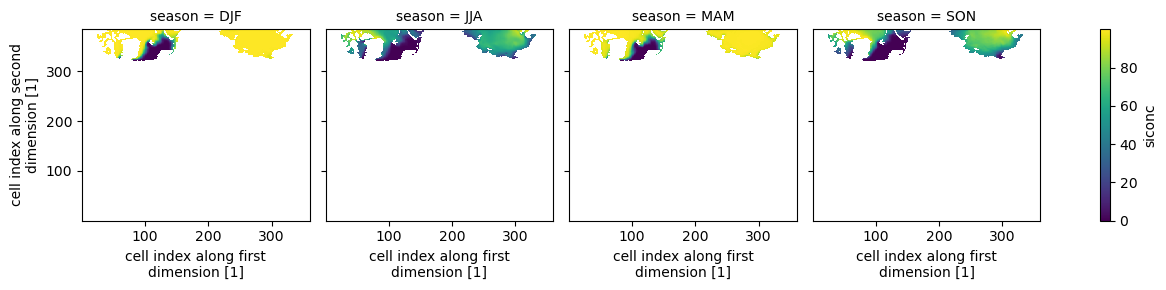

In [14]:
#d19['siconc'].plot(col='season')
d20['siconc'].plot(col='season')                      

In [15]:
import xesmf as xe

In [16]:
ds_out = xe.util.grid_global(1, 1)

In [17]:
dss_season19['lat'] = BSarea['latitude']
dss_season19['lon'] = BSarea['longitude']

NameError: name 'dss_season19' is not defined

In [47]:
regridder = xe.Regridder(d19, ds_out, 'bilinear')

<xarray.Dataset>
Dimensions:             (season: 4, j: 384, i: 360, vertices: 4)
Coordinates:
  * j                   (j) int32 1 2 3 4 5 6 7 ... 378 379 380 381 382 383 384
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
    longitude           (j, i) float64 dask.array<chunksize=(384, 360), meta=np.ndarray>
    type                |S7 b'sea_ice'
    latitude            (j, i) float64 dask.array<chunksize=(384, 360), meta=np.ndarray>
  * season              (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: vertices
Data variables:
    vertices_latitude   (season, j, i, vertices) float64 dask.array<chunksize=(1, 384, 360, 4), meta=np.ndarray>
    vertices_longitude  (season, j, i, vertices) float64 dask.array<chunksize=(1, 384, 360, 4), meta=np.ndarray>
    siconc              (season, j, i) float32 dask.array<chunksize=(1, 384, 360), meta=np.ndarray>

In [48]:
dr_out = regridder(d19['siconc'])

In [ ]:
f, ax = plt.subplots( subplot_kw=dict(projection=ccrs.Orthographic(0,90)))


W = ax.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=0),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
               )
               #col='season') 
    
f.colorbar(W , label='sea ice concentration [%]')
ax.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax.set_title('DJF Sea Ice Concentration (1900-1920)')
ax.gridlines(draw_labels=True) 
ax.coastlines()
f.tight_layout()    

In [ ]:
f, ax = plt.subplots(2,2 ,subplot_kw=dict(projection=ccrs.Orthographic(0,90)))
axs=ax.flatten()

ax1=axs[0] 
ax2=axs[1]
ax3=axs[2]
ax4=axs[3]



W = ax1.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=0),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
              )
               #col='season') 
    
S = ax2.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=1),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
             )
               #col='season')   

Sp = ax3.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=2),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
               )
               #col='season')     
    
A = ax4.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=3),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
                )
               #col='season')      

f.suptitle('H')    
  
f.colorbar(W , label='sea ice concentration [%]') #, ax=ax1)
ax1.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax1.set_title('DJF')
ax1.gridlines(draw_labels=True) 
ax1.coastlines()
plt.tight_layout()

#plt.colorbar(S , label='sea ice concentration [%]') #, ax=ax2)
ax2.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax2.set_title('JJA')
ax2.gridlines(draw_labels=True) 
ax2.coastlines()
plt.tight_layout()

#plt.colorbar(Sp , label='sea ice concentration [%]') #, ax=ax3)
ax3.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax3.set_title('MAM')
ax3.gridlines(draw_labels=True) 
ax3.coastlines()
plt.tight_layout()

#plt.colorbar(A , label='sea ice concentration [%]') #, ax=ax4)
ax4.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax4.set_title('SON')
ax4.gridlines(draw_labels=True) 
ax4.coastlines()
plt.tight_layout()

DJF
JJA
MAM
SON


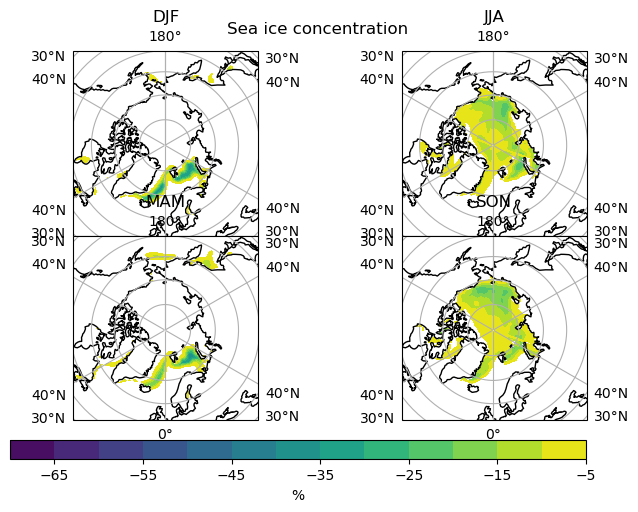

In [51]:
f, axs = plt.subplots(2,2 ,subplot_kw=dict(projection=ccrs.Orthographic(0,90)))
f.suptitle('Sea ice concentration')
axs=axs.flatten()
levels=np.arange(-50, 5, 5)

i=0

for season in dr_out.season.values: 
    print(season)
    cf=plotmap(axs[i], dr_out, season, levels)
    i= i+1 
cax = f.add_axes([.02, .07, .9, .04])
plt.colorbar(cf, cax=cax, orientation='horizontal', label='%') 
plt.subplots_adjust(left=0.05, bottom=.15, top= .92, right=.99, wspace=.2, hspace=.0)

In [40]:
dr_out

<xarray.DataArray (season: 4, y: 180, x: 360)>
dask.array<_regrid, shape=(4, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    type     |S7 b'sea_ice'
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear